In [27]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import statsmodels.api as sm
from math import sqrt

In [2]:
df = pd.read_csv('combined_transactions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             500 non-null    int64 
 1   transaction_type    500 non-null    object
 2   merchant_type_code  500 non-null    int64 
 3   amount_cents        500 non-null    int64 
 4   datetime            500 non-null    object
dtypes: int64(3), object(2)
memory usage: 19.7+ KB


In [3]:
df['amount_in_dollars'] = (df['amount_cents'] / 100).astype(int)
df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')

In [4]:
purchase5732 = df[(df['transaction_type'] == 'PurchaseActivity') & (df['merchant_type_code'] == 5732)]
purchase5732.set_index('datetime', inplace=True)
purchase5732.head()

,user_id,transaction_type,merchant_type_code,amount_cents,amount_in_dollars
datetime,,,,,
2023-03-14 11:57:58.383429,38493,PurchaseActivity,5732,4997,49
2023-03-14 12:11:14.747943,38493,PurchaseActivity,5732,9997,99
2023-03-14 12:10:34.933301,38493,PurchaseActivity,5732,9997,99
2023-03-15 11:48:12.613658,38493,PurchaseActivity,5732,1782,17
2023-03-15 11:54:24.734705,38493,PurchaseActivity,5732,6782,67


In [6]:
daily_data = purchase5732['amount_in_dollars'].resample('D').sum()
daily_data.head()

datetime
2023-03-14     247
2023-03-15    3896
2023-03-16    8032
2023-03-17    1078
2023-03-18       0
Freq: D, Name: amount_in_dollars, dtype: int64

In [8]:
model = ARIMA(daily_data, order=(1, 0, 0))
result = model.fit()

In [11]:
prediction = result.forecast(steps=10)
print(prediction)

2023-06-01    1001.414782
2023-06-02     604.304739
2023-06-03     476.157265
2023-06-04     434.804056
2023-06-05     421.459368
2023-06-06     417.153036
2023-06-07     415.763382
2023-06-08     415.314940
2023-06-09     415.170228
2023-06-10     415.123529
Freq: D, Name: predicted_mean, dtype: float64


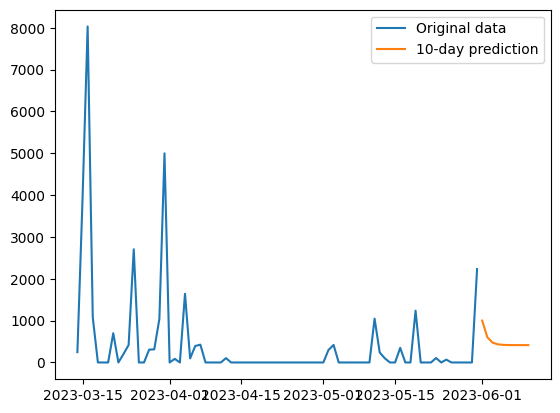

In [12]:
# Plot the original data and the prediction
plt.plot(daily_data, label='Original data')
plt.plot(prediction, label='10-day prediction')
plt.legend()
plt.show()

### Cross-validation

In [14]:
df_daily_data = pd.DataFrame(daily_data)
df_daily_data.head()

,amount_in_dollars
datetime,
2023-03-14,247
2023-03-15,3896
2023-03-16,8032
2023-03-17,1078
2023-03-18,0


In [20]:
# Assuming df_daily_data is your DataFrame
train_size = int(len(df_daily_data) * 0.8)
train, test = df_daily_data[0:train_size], df_daily_data[train_size:len(df_daily_data)]

model_train = ARIMA(train, order=(1, 0, 0))
result_train = model_train.fit()
y_pred = result_train.predict(start=len(train), end=len(train)+len(test)-1)

In [21]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

392.92492152896574


### Parameter Tuning

In [23]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
best_aic = np.inf
best_pdq = None
temp_model = None

for param in pdq:
    try:
        temp_model = sm.tsa.ARIMA(train, order=param)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print("Best ARIMA{} model - AIC:{}".format(best_pdq, best_aic))

/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yyy/anaconda3/lib/python3.10/site-packages/stat

Best ARIMA(2, 2, 2) model - AIC:1051.8394447805285


In [24]:
model_train_new = ARIMA(train, order=(2, 2, 2))
result_train_new = model_train_new.fit()
y_pred_new = result_train_new.predict(start=len(train), end=len(train)+len(test)-1)

rmse_new = mean_squared_error(y_test, y_pred_new, squared=False)
print(rmse_new)

/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


486.0540694059522


### Create validation set

In [25]:
train_size = int(len(df_daily_data) * 0.6)
val_size = int(len(df_daily_data) * 0.2)
train, val, test = df_daily_data[0:train_size], df_daily_data[train_size:train_size+val_size], df_daily_data[train_size+val_size:len(df_daily_data)]

In [29]:
# Train the model on the training set
model_train = ARIMA(train, order=(2, 2, 2))
result_train = model_train.fit()

# Make predictions on the validation set and calculate RMSE
val_pred = result_train.predict(start=len(train), end=len(train)+len(val)-1)
val_rmse = sqrt(mean_squared_error(val, val_pred))

# If the model's performance on the validation set is satisfactory, make predictions on the test set and calculate RMSE
test_pred = result_train.predict(start=len(train)+len(val), end=len(df_daily_data)-1)
test_rmse = sqrt(mean_squared_error(test, test_pred))
print(test_rmse)

1690.5592869674185


/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yyy/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [30]:
# For comparison

model_train_comp = ARIMA(train, order=(1, 0, 0))
result_train_comp = model_train_comp.fit()

# Make predictions on the validation set and calculate RMSE
val_pred_comp = result_train_comp.predict(start=len(train), end=len(train)+len(val)-1)
val_rmse_comp = sqrt(mean_squared_error(val, val_pred_comp))

# If the model's performance on the validation set is satisfactory, make predictions on the test set and calculate RMSE
test_pred_comp = result_train_comp.predict(start=len(train)+len(val), end=len(df_daily_data)-1)
test_rmse_comp = sqrt(mean_squared_error(test, test_pred_comp))
print(test_rmse_comp)

668.652074845482


## It's clear that the original model is better than the tuned one due to the overfitting for the latter one